# **Personal Details**
**Full name**: Konstantinos Gerogiannis  
**Studies**: Electrical and Computer Engineering, AUTh  
**Email**: kostas.gerogiannis04@gmail.com


## **Summary**
In this Colab, we attempt to create an autoencoder trained on the MNIST dataset, which was used in previous tasks. The autoencoder is designed to reconstruct the next digit in sequence as the output. The code is written in Python and utilizes the PyTorch library.

## **Importing libraries**

First, we import useful libraries:
* PyTorch libraries
* Matplotlib library for plotting graphs
* Time library for measuring code execution time
* NumPy library for efficient mathematical operations and handling large data
* Random library for random operations in the program

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from random import randint

## **Loading data: MNIST dataset**

We load the dataset's data into variables `train_dataset` and `validation_dataset` in tensor format (the data is downloaded from the appropriate website). We display the number of samples in the training and validation sets on the screen and choose to process 32 images at a time (batch size variable).

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
train_dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

test_dataset = datasets.MNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset
# for training
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 32,
                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                     batch_size = 32,
                                     shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Creating Class for the Autoencoder
First, we create a class that implements a simple autoencoder, which will reconstruct the input it receives. Initially, we create a sequential model that encodes the input image, and then immediately decodes it to generate a new image as output.

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Model initialization
We initialize the model, loss function, and optimizer. We choose the Adam optimizer after trying various options.

In [ ]:

# Model Initialization
model = AutoEncoder()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2)

In this model, separate functions have not been created for the training and test datasets. We only work with the training dataset, and the results it provides are satisfactory. More time has been devoted to the second part of the project, which also addresses the required task. We store the input and output images of the model for the last epoch in the variable "outputs."

In [ ]:
epochs = 4
outputs = []
epoch_losses = []

batch_size = len(train_loader)
for epoch in range(epochs):
    print(epoch)
    epoch_loss = 0
    losses = []
    for image,_ in train_loader:
      image = image.reshape(-1,28*28)
      
      reconstructed_image = model(image)
      loss = loss_function(reconstructed_image,image)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if epoch == epochs -1:
        outputs.append((image, reconstructed_image))

    epoch_losses.append(sum(losses)/len(losses))
print('Mean loss for each epoch:',epoch_losses)     

0
1
2
3
Mean loss for each epoch: [0.03887750139037768, 0.031461527596910795, 0.028844930124282835, 0.027499209127823512]


## Plotting some examples
We randomly choose to print a number of images and the corresponding output generated by the model on the screen.

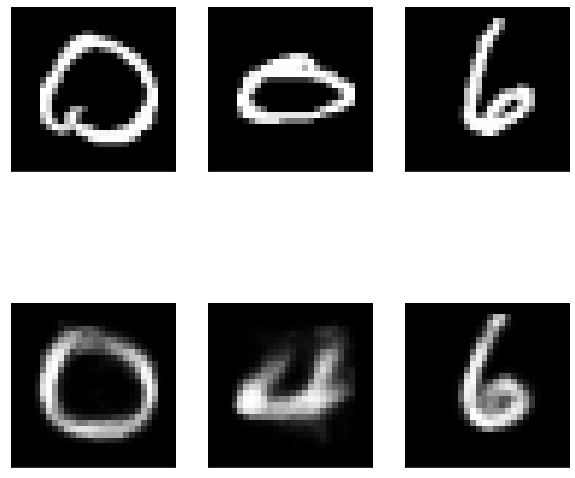

In [ ]:
number_of_samples = 3

fig = plt.figure(figsize=(10,10))
for i in range(number_of_samples):
  random_image = randint(0,len(outputs)-1)

  # Reshape the array for plotting
  image = outputs[random_image][0].reshape(-1, 28, 28)
  reconstructed = outputs[random_image][1].detach().reshape(-1, 28, 28)

  ax1 = fig.add_subplot('2'+str(number_of_samples)+str(i+1))
  ax1.get_xaxis().set_ticks([])
  ax1.get_yaxis().set_ticks([])
  plt.imshow(image[0],cmap='gray')

  ax2 = fig.add_subplot('2'+str(number_of_samples)+str(i+4))
  ax2.get_xaxis().set_ticks([])
  ax2.get_yaxis().set_ticks([])
  plt.imshow(reconstructed[0],cmap='gray')

## Conclusions about the simple autoencoder
We can draw the following conclusions about the simple autoencoder we created:

- Even with a small number of epochs (default: 4), its results are distinct and highly accurate.
- The few times the algorithm fails, it happens due to the peculiar handwriting of the input digit.

## Creating Class for the improved Autoencoder
We create this class to attempt the main goal of the task:

- To return the next digit from the autoencoder in relation to the one given as input.

This class is more complex because it has additional variables, and the `forward` function processes the results that come out after the image passes through the encoder. After processing, it is passed to the decoder, which generates the final output.

**Forward function:**

- When training the model, the function does not differ from the default function; it simply forwards the output of the encoder to the input of the decoder.
- In the last epoch of the learning process, the function stores the outputs of the encoder for each digit in the appropriate position in the `digit_strengths` dictionary. This dictionary consists of 10 keys, one for each digit, and each key points to a list of lists, where each list is a digit that has already been recorded in it.
- When testing the model (checking with the `validation` variable) and we are on the first input to the model, we calculate the averages of the `digit_strengths` dictionary for each digit. For example, for the digit 2, we have a list of 10 positions that shows the mean value we expect for the 10 output neurons of the encoder.
- In any other iteration on the test set, the above step is not performed. Then, we calculate for each input image, after it comes out of the encoder, which of the 10 digits it resembles the most by finding the Mean Squared Error (MSE) and selecting the smallest one.

In this way, we achieve a prediction with an accuracy of around 40%. I do not consider this accuracy satisfactory, but it is an improvement compared to the 10% random choice among 10 digits.

In [ ]:
class AutoEncoderImproved(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.validation = False
        self.digit_strengths =  {i: [] for i in range(10)}
        self.means =  {i: [] for i in range(10)}
        self.true_label = -1
        self.last_epoch = False
        self.predicted_labels=[]

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.tolist()
        if self.validation:
          if self.first_iter:
            for i in range(10):
              self.means[i]=np.mean(self.digit_strengths[i],axis = 0)
          self.predicted_labels=[]
          for i in range(len(encoded)):
            differences = []
            for j in range(10):
              differences.append(np.sum(np.power(np.subtract(encoded[i],self.means[j]),2)))
            next_label = np.argmin(differences)
            self.predicted_labels.append(next_label)
            next_label = (next_label+1)%10
            encoded[i][:] = self.digit_strengths[next_label][randint(0,len(self.digit_strengths[next_label])-1)]
        elif self.last_epoch:
          for i in range(len(encoded)):
            self.digit_strengths[self.true_label[i].item()].append(encoded[i])

        encoded = torch.Tensor(encoded)
        decoded = self.decoder(encoded)
        if self.validation:
          return self.predicted_labels,decoded
        return decoded

## Model initialization
We initialize the model, the loss function, and the optimizer. We choose the NAdam optimizer, which appears to be more effective here as it manages to achieve smaller losses compared to the standard Adam optimizer. The choice of optimizer involved many experiments with various functions and learning rate values.

In [ ]:
# Model Initialization
model = AutoEncoderImproved()

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.NAdam(model.parameters(),lr = 0.005)

In this model, we handle the train and test datasets differently. Initially, the train function is called, which trains the model and calculates the losses per epoch. Then, the validate function is called, where we test the trained model, ensuring that we do not further train it because the output it provides is no longer related to the input we provide, and it would confuse the optimizer (as it deals with different digits).

In [ ]:
from sklearn.metrics import accuracy_score
epochs = 4
outputs = []
losses = []
epoch_losses = []

def train(model):
  model.validation = False

  for epoch in range(epochs):
      if epoch == epochs -1:
        model.last_epoch = True
      print(epoch)
      losses = []
      count = 0
      for image,labels in train_loader:
        image = image.reshape(-1,28*28)
        model.true_label = labels
        reconstructed_image = model(image)
        loss = loss_function(reconstructed_image,image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

      epoch_losses.append(sum(losses)/len(losses))
  print('Mean loss per epoch in training set:',epoch_losses)

def validate(model):
  scores = []
  print('Starting validation')
  model.validation = True
  counter = 0
  for image,labels in test_loader:
      image = image.reshape(-1,28*28)
      model.true_label = labels
      counter = counter + 1
      with torch.no_grad():
        if counter == 1:
          model.first_iter = True
        else:
          model.first_iter = False
        predicted_labels,reconstructed_image = model(image) 
        outputs.append((image, reconstructed_image))
        scores.append(accuracy_score(predicted_labels,labels))
  print('Validation finished')
  print('accuracy score:',np.mean(scores))

train(model)
validate(model)


0
1
2
3
Mean loss per epoch in training set: [0.06247430200775465, 0.05345585763454437, 0.049341263512770336, 0.04708816176851591]
Starting validation
Validation finished
accuracy score: 0.40964456869009586


313
32


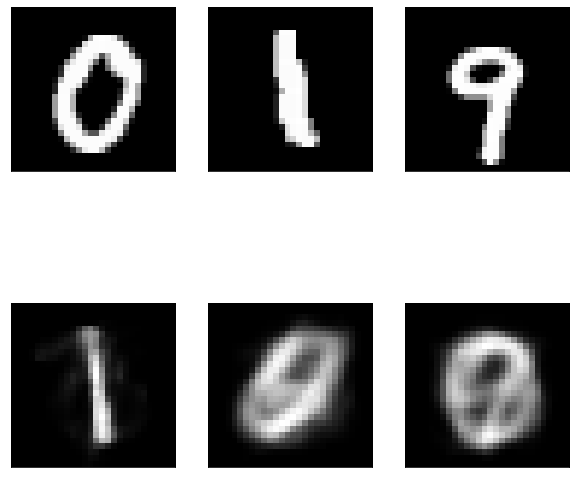

In [ ]:
number_of_samples = 3
print(len(outputs))
print(len(outputs[0][0]))
fig = plt.figure(figsize=(10,10))
for i in range(number_of_samples):
  random_image = randint(0,len(outputs)-1)
  random_sample = randint(0,len(outputs[random_image][0])-1)
  # Reshape the array for plotting
  image = outputs[random_image][0].reshape(-1, 28, 28)
  reconstructed = outputs[random_image][1].reshape(-1, 28, 28)

  ax1 = fig.add_subplot('2'+str(number_of_samples)+str(i+1))
  ax1.get_xaxis().set_ticks([])
  ax1.get_yaxis().set_ticks([])
  plt.imshow(image[random_sample],cmap='gray')

  ax2 = fig.add_subplot('2'+str(number_of_samples)+str(i+4))
  ax2.get_xaxis().set_ticks([])
  ax2.get_yaxis().set_ticks([])
  plt.imshow(reconstructed[random_sample],cmap='gray')

## Conclusions about the improved autoencoder
An attempt was made for the autoencoder to achieve its goal, but the results are not entirely satisfactory.
* There are some cases where the result is clearly correct.
* Sometimes, with a bit of imagination, the correct result does indeed emerge at the output.
* In the remaining cases, the output is not as desired.

Various approaches to the problem and many experiments were conducted, but unfortunately, none reached a satisfactory level to solve the problem. However, since many hours and effort were dedicated to this, I wanted to submit the work along with the simplified model that I retained, as the more complex approaches to the problem did not yield results.

## **Reducing training time with PCA**

In this specific Colab notebook, there are already accuracy issues, and the focus is not primarily on the computation time. The PCA method will be used, and we will compare the times and further assess the impact on the model's accuracy.

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
train_dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

test_dataset = datasets.MNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = tensor_transform)
 

- We create the function `transform_data` where we input the data we want to transform and the dimension we want to reduce it to using PCA. The function will return the transformed data after applying the transformation.
- Additionally, we create the class `TransformedDataset` to enable us to save the new data because this cannot be done with the basic `Dataset` class in PyTorch.

In [ ]:
from sklearn.decomposition import PCA
from torch.utils.data import Dataset

def transform_data(data,n_components=256):
  # Flatten
  data = data.view(data.size(0), -1)
  data = data.float()

  mean = data.mean()
  std = data.std()
  data = (data - mean) / std

  pca = PCA(n_components=n_components)
  data = pca.fit_transform(data)
  data = (torch.tensor(data)).type(torch.FloatTensor)
  return data


train_data = train_dataset.data
print('train data dimensions before PCA:',train_data.shape)
train_data = transform_data(train_data)
print('train data dimensions after PCA:',train_data.shape)
test_data = test_dataset.data
print('test data dimensions before PCA:',test_data.shape)
test_data = transform_data(test_data)
print('test data dimensions after PCA:',test_data.shape)

class TransformedDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

train_labels = train_dataset.targets
test_labels = test_dataset.targets

train_dataset = TransformedDataset(data=train_data, labels=train_labels)
test_dataset = TransformedDataset(data=test_data, labels=test_labels)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 32,
                                     shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                     batch_size = 32,
                                     shuffle=False)


train data dimensions before PCA: torch.Size([60000, 28, 28])
train data dimensions after PCA: torch.Size([60000, 256])
test data dimensions before PCA: torch.Size([10000, 28, 28])
test data dimensions after PCA: torch.Size([10000, 256])


The model we create here for PCA functions similarly to the improved autoencoder defined previously, with the only difference being in the number of neurons and layers used in the encoder and decoder.

In [ ]:
class AutoEncoderImprovedPCA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.validation = False
        self.digit_strengths =  {i: [] for i in range(10)}
        self.means =  {i: [] for i in range(10)}
        self.true_label = -1
        self.last_epoch = False
        self.predicted_labels=[]

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 10)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.tolist()
        if self.validation:
          if self.first_iter:
            for i in range(10):
              self.means[i]=np.mean(self.digit_strengths[i],axis = 0)
          self.predicted_labels=[]
          for i in range(len(encoded)):
            differences = []
            for j in range(10):
              differences.append(np.sum(np.power(np.subtract(encoded[i],self.means[j]),2)))
            next_label = np.argmin(differences)
            self.predicted_labels.append(next_label)
            next_label = (next_label+1)%10
            encoded[i][:] = self.digit_strengths[next_label][randint(0,len(self.digit_strengths[next_label])-1)]
        elif self.last_epoch:
          for i in range(len(encoded)):
            self.digit_strengths[self.true_label[i].item()].append(encoded[i])

        encoded = torch.Tensor(encoded)
        decoded = self.decoder(encoded)
        if self.validation:
          return self.predicted_labels,decoded
        return decoded

## Model initialization
We initialize the model, the loss function and the optimizer. We choose as the suitable optimizer the simple Adam.

In [ ]:
# Model Initialization
model = AutoEncoderImprovedPCA()

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)

With the same functionality as before, the model is trained and tested. The speeds after applying PCA are significantly faster, and we can run the model with more epochs in the same time frame. However, the accuracy has deteriorated, dropping to 15%, very close to random selection, which is a very disappointing result.

In [ ]:
from sklearn.metrics import accuracy_score
epochs = 10
outputs = []
losses = []
epoch_losses = []

def train(model):
  model.validation = False

  for epoch in range(epochs):
      if epoch == epochs -1:
        model.last_epoch = True
      print(epoch)
      losses = []
      count = 0
      for image,labels in train_loader:
        model.true_label = labels
        reconstructed_image = model(image)
        loss = loss_function(reconstructed_image,image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

      epoch_losses.append(sum(losses)/len(losses))
  print('Mean loss per epoch in training set:',epoch_losses)

def validate(model):
  scores = []
  print('Starting validation')
  model.validation = True
  counter = 0
  for image,labels in test_loader:
      model.true_label = labels
      counter = counter + 1
      with torch.no_grad():
        if counter == 1:
          model.first_iter = True
        else:
          model.first_iter = False
        predicted_labels,reconstructed_image = model(image) 
        outputs.append((image, reconstructed_image))
        scores.append(accuracy_score(predicted_labels,labels))
  print('Validation finished')
  print('accuracy score:',np.mean(scores))

train(model)
validate(model)


0
1
2
3
4
5
6
7
8
9
Mean loss per epoch in training set: [2.073868380101522, 2.0402763151168823, 2.0270871262232464, 2.019866829999288, 2.009192009226481, 2.003223336919149, 2.0009183037439984, 1.9992174067815145, 1.9979145523707071, 1.9969201606114706]
Starting validation
Validation finished
accuracy score: 0.14586661341853036
